In [1]:
from tensorflow.keras.datasets import cifar10
from image import *
from hashlib import md5
import numpy as np
import pandas as pd
import os
import shutil
import warnings
warnings.filterwarnings('ignore')
import cv2 as cv


def get_data(param):
    if param["dataset"] == "CIFAR10":
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype(np.float) / 255.
        x_test = x_test.astype(np.float) / 255.

    if param["dataset"] == "GTSRB":
        train_X = []
        train_y = []
        for i in range(0,43):
            n = str(i)
            train_Path = "gtsrb-german-traffic-sign/Train/" + n
            label = [0 for i in range(0, 43)]
            label[i] = 1
            for filename in os.listdir(train_Path):
                img = cv.imread(train_Path + "/" + filename)
                img = cv.resize(img, (32,32))
                #print(filename)
                train_X.append(img)
                train_y.append(label)
        train_X = np.asarray(train_X)
        
        train_X = np.asarray(train_X, dtype = "float32")
        train_y = np.asarray(train_y, dtype= "float32")
        
        meta_df = pd.read_csv('gtsrb-german-traffic-sign/Meta.csv')
        test_data = pd.read_csv('gtsrb-german-traffic-sign/Test.csv')
        train_data = pd.read_csv('gtsrb-german-traffic-sign/Train.csv')
        
        counter = 0
        test_X = []
        test_y = []
        test_Path = "gtsrb-german-traffic-sign/Test"
        for filename in os.listdir(test_Path):
                img = cv.imread(test_Path + "/" + filename)
                img = cv.resize(img, (32,32))
                label = [0 for i in range(0, 43)]
                label[test_data.loc[counter][6]] = 1
                #print(filename)
                test_X.append(img)
                test_y.append(label)
                counter += 1
        test_X = np.asarray(test_X)
        
        test_X = np.asarray(test_X, dtype = "float32")
        test_y = np.asarray(test_y, dtype= "float32")
        
        train_y_after = [[0] * 1] * 39209

        for i in range(39209):
            for j in range(43):
                if (train_y[i][j] == 1):
                    train_y_after[i] = [j]
        y_train = train_y_after
        y_train = np.array(y_train)
        
        test_y_after = [[0] * 1] * 12630

        for i in range(12630):
            j = test_data["ClassId"][i]
            test_y_after[i] = [j]
        y_test = test_y_after
        y_test = np.array(y_test)
        
        #shuffle training set 
        index = np.arange(39209)
        np.random.shuffle(index)
        train_X = train_X[index,:,:,:]
        y_train = y_train[index]
        
        
        x_train = train_X.astype(np.float)
        x_test = test_X.astype(np.float)

    return x_train, y_train, x_test, y_test


def poison(x_train, y_train, param):
    target_label = param["target_label"]
    num_images = int(param["poisoning_rate"] * y_train.shape[0])

    index = np.where(y_train != target_label)
    index = index[0]
    index = index[:num_images]
    x_train[index] = poison_frequency(x_train[index], y_train[index], param)
    y_train[index] = target_label
    return x_train


def poison_frequency(x_train, y_train, param):
    if x_train.shape[0] == 0:
        return x_train

    x_train *= 255.
    if param["YUV"]:
        x_train = RGB2YUV(x_train)

    # transfer to frequency domain
    x_train = DCT(x_train, param["window_size"])  # (idx, ch, w, h)

    # plug trigger frequency
    for i in range(x_train.shape[0]):
        for ch in param["channel_list"]:
            for w in range(0, x_train.shape[2], param["window_size"]):
                for h in range(0, x_train.shape[3], param["window_size"]):
                    for pos in param["pos_list"]:
                        x_train[i][ch][w + pos[0]][h + pos[1]] += param["magnitude"]


    x_train = IDCT(x_train, param["window_size"])  # (idx, w, h, ch)

    if param["YUV"]:
        x_train = YUV2RGB(x_train)

    x_train /= 255.
    x_train = np.clip(x_train, 0, 1)
    return x_train


def impose(x_train, y_train, param):
    x_train = poison_frequency(x_train, y_train, param)
    return x_train


def digest(param):
    txt = ""
    txt += param["dataset"]
    txt += str(param["target_label"])
    txt += str(param["poisoning_rate"])
    txt += str(param["label_dim"])
    txt += "".join(str(param["channel_list"]))
    txt += str(param["window_size"])
    txt += str(param["magnitude"])
    txt += str(param["YUV"])
    txt += "".join(str(param["pos_list"]))
    hash_md5 = md5()
    hash_md5.update(txt.encode("utf-8"))
    return hash_md5.hexdigest()

In [2]:
import math
from skimage import transform, data
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
import bm3d
import scipy.signal

def RGB2YUV(x_rgb):
    x_yuv = np.zeros(x_rgb.shape, dtype=np.float)
    for i in range(x_rgb.shape[0]):
        img = cv2.cvtColor(x_rgb[i].astype(np.uint8), cv2.COLOR_RGB2YCrCb)
        x_yuv[i] = img
    return x_yuv

def YUV2RGB(x_yuv):
    x_rgb = np.zeros(x_yuv.shape, dtype=np.float)
    for i in range(x_yuv.shape[0]):
        img = cv2.cvtColor(x_yuv[i].astype(np.uint8), cv2.COLOR_YCrCb2RGB)
        x_rgb[i] = img
    return x_rgb


def DCT(x_train, window_size):
    # x_train: (idx, w, h, ch)
    x_dct = np.zeros((x_train.shape[0], x_train.shape[3], x_train.shape[1], x_train.shape[2]), dtype=np.float)
    x_train = np.transpose(x_train, (0, 3, 1, 2))

    for i in range(x_train.shape[0]):
        for ch in range(x_train.shape[1]):
            for w in range(0, x_train.shape[2], window_size):
                for h in range(0, x_train.shape[3], window_size):
                    sub_dct = cv2.dct(x_train[i][ch][w:w+window_size, h:h+window_size].astype(np.float))
                    x_dct[i][ch][w:w+window_size, h:h+window_size] = sub_dct
    return x_dct            # x_dct: (idx, ch, w, h)


def IDCT(x_train, window_size):
    # x_train: (idx, ch, w, h)
    x_idct = np.zeros(x_train.shape, dtype=np.float)

    for i in range(x_train.shape[0]):
        for ch in range(0, x_train.shape[1]):
            for w in range(0, x_train.shape[2], window_size):
                for h in range(0, x_train.shape[3], window_size):
                    sub_idct = cv2.idct(x_train[i][ch][w:w+window_size, h:h+window_size].astype(np.float))
                    x_idct[i][ch][w:w+window_size, h:h+window_size] = sub_idct
    x_idct = np.transpose(x_idct, (0, 2, 3, 1))
    return x_idct


def Gaussian(x_train):
    # x_train: (idx, w, h, ch)
    x_train = x_train * 255
    for i in range(x_train.shape[0]):
        x_train[i] = cv2.GaussianBlur(x_train[i], (5, 5), sigmaX=0, sigmaY=0)
    x_train = x_train / 255.
    return x_train


def BM3D(x_train):
    x_train = x_train * 255
    for i in range(x_train.shape[0]):
        x_train[i] = bm3d.bm3d(x_train[i], sigma_psd=1)
    x_train = x_train / 255.
    return x_train


def Wiener(x_train):
    x_train = x_train * 255
    for i in range(x_train.shape[0]):
        img = np.transpose(x_train[i], (2, 0, 1))
        windows_size = (5, 5)
        img[0] = scipy.signal.wiener(img[0], windows_size)
        img[1] = scipy.signal.wiener(img[1], windows_size)
        img[2] = scipy.signal.wiener(img[2], windows_size)
        img = np.transpose(img, (1, 2, 0))
        x_train[i] = img
    x_train /= 255.
    return x_train


def PSNR(img1, img2):
    img1 = np.float64(img1)
    img2 = np.float64(img2)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


def IS_score(img1, img2):
    img1 = transform.resize(img1, (299, 299))
    img1 = np.reshape(img1, (-1, 299, 299, 3))
    img2 = transform.resize(img2, (299, 299))
    img2 = np.reshape(img2, (-1, 299, 299, 3))
    model = InceptionV3(include_top=True, weights='imagenet',classes=1000)
    x1 = tf.keras.applications.inception_v3.preprocess_input(img1)
    x2 = tf.keras.applications.inception_v3.preprocess_input(img2)
    y1 = model(x1).numpy().reshape((-1))
    y2 = model(x2).numpy().reshape((-1))
    KL = 0.0
    for i in range(1000):
        KL += y1[i] * np.log(y1[i] / y2[i])
    return KL

def SSIM(img1, img2):
    res = skimage.metrics.structural_similarity(img1, img2, win_size=9, multichannel=True)
    return res


def get_visual_values(imgs1, imgs2):
    iss, psnr, ssim, l2 = 0.0, 0.0, 0.0, 0.0
    for i in range(imgs1.shape[0]):
        psnr += PSNR(imgs1[i], imgs2[i])
        ssim += SSIM(imgs1[i], imgs2[i])
        iss += IS_score(imgs1[i], imgs2[i])

    return psnr/imgs1.shape[0], ssim/imgs1.shape[0], iss/imgs1.shape[0]

In [3]:
import tensorflow.keras.regularizers as regularizers
from tensorflow.python.keras.layers import Activation, Conv2D
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from keras import backend as K

def get_model(param):
    if param["dataset"] == "CIFAR10":
        return _get_model_cifar()
    if param["dataset"] == "GTSRB":
        return _get_model_GTSRB()
    if param["dataset"] == "ImageNet16":
        return _get_model_ImageNet16()
    if param["dataset"] == "PubFig":
        return _get_model_PubFig()

    return None


def _get_model_cifar():
    weight_decay = 1e-6
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(32, 32, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model


def _get_model_GTSRB():

    weight_decay = 1e-6
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(32, 32, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(43, activation='softmax'))

    return model



def _get_model_ImageNet16():
    model = ResNet50V2(input_shape=(224, 224, 3), weights=None, classes=16)
    return model

def _get_model_PubFig():
    model = ResNet50V2(input_shape=(224, 224, 3), weights=None, classes=16)
    return model


def _get_model_GTSRB_new():
    model = ResNet50V2(input_shape=(224,224,3), weights=None, classes=13)
    return model

Using TensorFlow backend.


In [4]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow import keras as keras
import matplotlib.pyplot as plt
from multiprocessing import Process
from tqdm import tqdm
%matplotlib inline

clean_valid_set = [0, 0, 0, 0]
attack_success_set = [0, 0, 0, 0]
totalPercentChannelsRemoved = np.zeros((128))
totalCleanAccuracyValid = np.zeros((128))
totalAttackSuccessRateValid = np.zeros((128))
totalCleanAccuracyTest = np.zeros((128))
totalAttackSuccessRateTest = np.zeros((128))
percentValidationAccuracy = []
clean_accuracy = 0


def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    elif epoch > 20:
        lrate = 0.0003
    else:
        lrate = 0.0001
    return lrate


def defense():
    param = {
        "dataset": "GTSRB",           # GTSRB
        "target_label": 10,              # target label
        "poisoning_rate": 0.05,         # ratio of poisoned samples
        "label_dim": 43,
        "channel_list": [1, 2],         # [0,1,2] means YUV channels, [1,2] means UV channels
        "magnitude": 30,
        "YUV": True,
        "window_size": 32,
        "pos_list": [(15, 15), (31, 31)],
    }

    x_train, y_train, x_test, y_test = get_data(param)
    cl_x_valid = x_train
    cl_y_valid = y_train
    cl_y_valid = keras.utils.to_categorical(cl_y_valid, param["label_dim"])

    x_train = poison(x_train, y_train, param)

    x_test_pos = impose(x_test.copy(), y_test.copy(), param)
    y_test_pos = np.array([[param["target_label"]]] * x_test_pos.shape[0], dtype=np.long)

    param["input_shape"] = x_train.shape[1:]
    y_train = keras.utils.to_categorical(y_train, param["label_dim"])
    y_test = keras.utils.to_categorical(y_test, param["label_dim"])
    y_test_pos = keras.utils.to_categorical(y_test_pos, param["label_dim"])
    
    cl_x_test = x_test
    cl_y_test = y_test
    bd_x_valid = x_test_pos
    bd_y_valid = y_test_pos

    model = get_model(param)
    B = get_model(param)

    filepath = "model/e885e2ec2414bdb0495347e5e59fbfba.hdf5"
 
    B.load_weights(filepath)
    model.load_weights(filepath)
    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    scores_normal = model.evaluate(cl_x_valid, cl_y_valid, batch_size=128, verbose=1)
    clean_accuracy = scores_normal[1] * 100
    print("Clean validation accuracy before pruning {0:3.6f}".format(clean_accuracy))
    K.clear_session()
    
    flag = [0, 0, 0, 0]
    i = 0
    # Redefine model to output right after the last pooling layer ("max_pooling2d_2")
    intermediate_model = Model(inputs=model.inputs, outputs=model.get_layer('max_pooling2d_2').output)

    # Get feature map for last pooling layer ("pool_3") using the clean validation data and intermediate_model
    feature_maps_cl = intermediate_model.predict(cl_x_valid)

    # Get average activation value of each channel in last pooling layer ("max_pooling2d_2")
    averageActivationsCl = np.mean(feature_maps_cl,axis=(0,1,2))

    # Store the indices of average activation values (averageActivationsCl) in increasing order
    idxToPrune = np.argsort(averageActivationsCl)

    # Get the conv_4 layer weights and biases from the original network that will be used for prunning

    lastConvLayerWeights = model.layers[19].get_weights()[0]
    lastConvLayerBiases  = model.layers[19].get_weights()[1]

    #prun channel with lowest weight first
    for chIdx in tqdm(idxToPrune):

        # Prune one channel at a time
        lastConvLayerWeights[:,:,:,chIdx] = 0
        lastConvLayerBiases[chIdx] = 0

        # Update weights and biases of B_clone
        model.layers[19].set_weights([lastConvLayerWeights, lastConvLayerBiases])

        # Evaluate the updated model's (B_clone) clean validation accuracy
        scores_normal = model.evaluate(cl_x_valid, cl_y_valid, batch_size=128, verbose=1)
        clean_accuracy_valid = scores_normal[1] * 100
        print(" ________________________")
        #print(clean_accuracy)
        print("Accuracy drops {0:3.6f}".format(clean_accuracy-clean_accuracy_valid))
        #print(clean_accuracy_valid)
        # If drop in clean_accuracy_valid is just greater (or equal to) than the desired threshold compared to clean_accuracy, then save B_clone as B_prime 
        if clean_accuracy - clean_accuracy_valid >= 2 and not flag[0]:
            # Save B_clone as B_prime 
            print("The accuracy drops at least 2%, saved the model")
            model.save('model_X=2.h5')
            model.save_weights('weightX=2.h5')
            flag[0] = 1
        if clean_accuracy - clean_accuracy_valid >= 10 and not flag[1]:
            # Save B_clone as B_prime 
            print("The accuracy drops at least 10%, saved the model")
            model.save('model_X=10.h5')
            model.save_weights('weightX=10.h5')
            flag[1] = 1
        if clean_accuracy - clean_accuracy_valid >= 20 and not flag[2]:
            # Save B_clone as B_prime 
            print("The accuracy drops at least 20%, saved the model")
            model.save('model_X=20.h5')
            model.save_weights('weightX=20.h5')
            flag[2] = 1
        if clean_accuracy - clean_accuracy_valid >= 30 and not flag[3]:
            # Save B_clone as B_prime 
            print("The accuracy drops at least 30%, saved the model")
            model.save('model_X=30.h5')
            model.save_weights('weightX=30.h5')
            flag[3] = 1
        
        scores_normal_2 = model.evaluate(cl_x_test, cl_y_test, batch_size=128, verbose=1)
        clean_accuracy_test = scores_normal_2[1] * 100
        print("Clean test accuracy {0:3.6f}".format(clean_accuracy_test))
        bd_scores_normal_2 = model.evaluate(bd_x_valid, bd_y_valid, batch_size=128, verbose=1)
        asr_test = bd_scores_normal_2[1] * 100
        print("Attack success rate {0:3.6f}".format(asr_test))
        percentChannelsRemoved=(i + 1) / lastConvLayerWeights.shape[3]
        
        K.clear_session()

        totalPercentChannelsRemoved[i] = percentChannelsRemoved
        totalCleanAccuracyValid[i] = clean_accuracy_valid
        totalCleanAccuracyTest[i] = clean_accuracy_test
        totalAttackSuccessRateTest[i] = asr_test
        i+=1
        
    
    
    
    B_prime2 = keras.models.load_model("model_X=2.h5")
    B_prime2.load_weights("weightX=2.h5")
    
    B_prime10 = keras.models.load_model("model_X=10.h5")
    B_prime10.load_weights("weightX=10.h5")
    
    B_prime20 = keras.models.load_model("model_X=20.h5")
    B_prime20.load_weights("weightX=20.h5")
    
    B_prime30 = keras.models.load_model("model_X=30.h5")
    B_prime30.load_weights("weightX=30.h5")
    

    
    scores_normal_2 = B_prime2.evaluate(cl_x_test, y_test, batch_size=128, verbose=1)
    clean_accuracy_valid_2 = scores_normal_2[1] * 100
    print('Clean Classification accuracy for B_prime2:', clean_accuracy_valid_2)

    bd_scores_normal_2 = B_prime2.evaluate(bd_x_valid, bd_y_valid, batch_size=128, verbose=1)
    asr_2 = bd_scores_normal_2[1] * 100
    print('Attack Success Rate for B_prime2:', asr_2)
    
    clean_valid_set[0] = clean_accuracy_valid_2
    attack_success_set[0] = asr_2
    
    scores_normal_10 = B_prime10.evaluate(cl_x_test, cl_y_test, batch_size=128, verbose=1)
    clean_accuracy_valid_10 = scores_normal_10[1] * 100
    print('Clean Classification accuracy for B_prime10:', clean_accuracy_valid_10)

    bd_scores_normal_10 = B_prime10.evaluate(bd_x_valid, bd_y_valid, batch_size=128, verbose=1)
    asr_10 = bd_scores_normal_10[1] * 100
    print('Attack Success Rate for B_prime10:', asr_10)
    
    clean_valid_set[1] = clean_accuracy_valid_10
    attack_success_set[1] = asr_10
    
    scores_normal_20 = B_prime20.evaluate(cl_x_test, cl_y_test, batch_size=128, verbose=1)
    clean_accuracy_valid_20 = scores_normal_20[1] * 100
    print('Clean Classification accuracy for B_prime20:', clean_accuracy_valid_20)

    bd_scores_normal_20 = B_prime20.evaluate(bd_x_valid, bd_y_valid, batch_size=128, verbose=1)
    asr_20 = bd_scores_normal_20[1] * 100
    print('Attack Success Rate for B_prime20:', asr_20)
    
    clean_valid_set[2] = clean_accuracy_valid_20
    attack_success_set[2] = asr_20
    
    scores_normal_30 = B_prime30.evaluate(cl_x_test, cl_y_test, batch_size=128, verbose=1)
    clean_accuracy_valid_30 = scores_normal_30[1] * 100
    print('Clean Classification accuracy for B_prime30:', clean_accuracy_valid_30)

    bd_scores_normal_30 = B_prime30.evaluate(bd_x_valid, bd_y_valid, batch_size=128, verbose=1)
    asr_30 = bd_scores_normal_30[1] * 100
    print('Attack Success Rate for B_prime30:', asr_30)
    
    clean_valid_set[3] = clean_accuracy_valid_30
    attack_success_set[3] = asr_30
        
if __name__ == "__main__":
    # To avoid keras eat all GPU memory
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    defense()



307/307 [==============================] - 3s 4ms/step - loss: 1.8964 - accuracy: 0.9500
Clean validation accuracy before pruning 94.998598


  0%|          | 0/128 [00:00<?, ?it/s]

307/307 [==============================] - 1s 3ms/step - loss: 1.9235 - accuracy: 0.9500
 ________________________
Accuracy drops 0.002551
99/99 [==============================] - 0s 4ms/step - loss: 0.0874 - accuracy: 0.9861
Clean test accuracy 98.614413
99/99 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000


  1%|          | 1/128 [00:02<04:19,  2.05s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.9231 - accuracy: 0.9500
 ________________________
Accuracy drops 0.002551
99/99 [==============================] - 0s 3ms/step - loss: 0.0881 - accuracy: 0.9861
Clean test accuracy 98.606491
99/99 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000


  2%|▏         | 2/128 [00:04<04:15,  2.03s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.9250 - accuracy: 0.9499
 ________________________
Accuracy drops 0.007653
99/99 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9859
Clean test accuracy 98.590660
99/99 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000


  2%|▏         | 3/128 [00:05<04:06,  1.97s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8900 - accuracy: 0.9499
 ________________________
Accuracy drops 0.007653
99/99 [==============================] - 0s 3ms/step - loss: 0.0936 - accuracy: 0.9857
Clean test accuracy 98.566902
99/99 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000


  3%|▎         | 4/128 [00:07<04:03,  1.97s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8952 - accuracy: 0.9499
 ________________________
Accuracy drops 0.007653
99/99 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9854
Clean test accuracy 98.535234
99/99 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000


  4%|▍         | 5/128 [00:09<03:59,  1.95s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8880 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.0977 - accuracy: 0.9848
Clean test accuracy 98.479807
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  5%|▍         | 6/128 [00:11<03:54,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8881 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9849
Clean test accuracy 98.487729
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  5%|▌         | 7/128 [00:13<03:51,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8646 - accuracy: 0.9499
 ________________________
Accuracy drops 0.012755
99/99 [==============================] - 0s 3ms/step - loss: 0.1002 - accuracy: 0.9843
Clean test accuracy 98.432302
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  6%|▋         | 8/128 [00:15<03:49,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8852 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.1014 - accuracy: 0.9842
Clean test accuracy 98.416471
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  7%|▋         | 9/128 [00:17<03:47,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8921 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.1004 - accuracy: 0.9841
Clean test accuracy 98.408550
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  8%|▊         | 10/128 [00:19<03:44,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.8159 - accuracy: 0.9499
 ________________________
Accuracy drops 0.012755
99/99 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9839
Clean test accuracy 98.392713
99/99 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 1.0000


  9%|▊         | 11/128 [00:21<03:42,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.7940 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.1034 - accuracy: 0.9834
Clean test accuracy 98.337293
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


  9%|▉         | 12/128 [00:23<03:39,  1.89s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.7615 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.9827
Clean test accuracy 98.273951
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 10%|█         | 13/128 [00:25<03:38,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6948 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1039 - accuracy: 0.9826
Clean test accuracy 98.258114
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 11%|█         | 14/128 [00:26<03:36,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6319 - accuracy: 0.9499
 ________________________
Accuracy drops 0.012755
99/99 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9829
Clean test accuracy 98.289788
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 12%|█▏        | 15/128 [00:28<03:34,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6456 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1029 - accuracy: 0.9828
Clean test accuracy 98.281866
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 12%|█▎        | 16/128 [00:30<03:32,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6434 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9821
Clean test accuracy 98.210609
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 13%|█▎        | 17/128 [00:32<03:30,  1.89s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6432 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9813
Clean test accuracy 98.131430
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 14%|█▍        | 18/128 [00:34<03:27,  1.89s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6521 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9812
Clean test accuracy 98.123515
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 15%|█▍        | 19/128 [00:36<03:26,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6201 - accuracy: 0.9499
 ________________________
Accuracy drops 0.012755
99/99 [==============================] - 0s 3ms/step - loss: 0.1087 - accuracy: 0.9808
Clean test accuracy 98.076010
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 16%|█▌        | 20/128 [00:38<03:25,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6266 - accuracy: 0.9499
 ________________________
Accuracy drops 0.010204
99/99 [==============================] - 0s 3ms/step - loss: 0.1046 - accuracy: 0.9813
Clean test accuracy 98.131430
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 16%|█▋        | 21/128 [00:40<03:23,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.5946 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9812
Clean test accuracy 98.123515
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 17%|█▋        | 22/128 [00:42<03:21,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.6342 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1046 - accuracy: 0.9811
Clean test accuracy 98.107678
99/99 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000


 18%|█▊        | 23/128 [00:43<03:19,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.5581 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9809
Clean test accuracy 98.091847
99/99 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


 19%|█▉        | 24/128 [00:45<03:18,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.5450 - accuracy: 0.9498
 ________________________
Accuracy drops 0.020403
99/99 [==============================] - 0s 4ms/step - loss: 0.1083 - accuracy: 0.9802
Clean test accuracy 98.020583
99/99 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000


 20%|█▉        | 25/128 [00:47<03:20,  1.94s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.5542 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9790
Clean test accuracy 97.901821
99/99 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


 20%|██        | 26/128 [00:49<03:18,  1.95s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.5495 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9779
Clean test accuracy 97.790974
99/99 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


 21%|██        | 27/128 [00:51<03:15,  1.94s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4941 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9786
Clean test accuracy 97.862232
99/99 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


 22%|██▏       | 28/128 [00:53<03:15,  1.95s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4828 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1187 - accuracy: 0.9778
Clean test accuracy 97.783059
99/99 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


 23%|██▎       | 29/128 [00:55<03:11,  1.93s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4481 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 3ms/step - loss: 0.1186 - accuracy: 0.9777
Clean test accuracy 97.767222
99/99 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000


 23%|██▎       | 30/128 [00:57<03:12,  1.97s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4486 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9781
Clean test accuracy 97.806811
99/99 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000


 24%|██▍       | 31/128 [00:59<03:14,  2.01s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4473 - accuracy: 0.9498
 ________________________
Accuracy drops 0.015301
99/99 [==============================] - 0s 4ms/step - loss: 0.1230 - accuracy: 0.9778
Clean test accuracy 97.775137
99/99 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000


 25%|██▌       | 32/128 [01:01<03:16,  2.04s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4348 - accuracy: 0.9499
 ________________________
Accuracy drops 0.012755
99/99 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9781
Clean test accuracy 97.806811
99/99 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000


 26%|██▌       | 33/128 [01:03<03:11,  2.02s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4383 - accuracy: 0.9498
 ________________________
Accuracy drops 0.017852
99/99 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9777
Clean test accuracy 97.767222
99/99 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000


 27%|██▋       | 34/128 [01:05<03:07,  2.00s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4390 - accuracy: 0.9497
 ________________________
Accuracy drops 0.025505
99/99 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9781
Clean test accuracy 97.806811
99/99 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000


 27%|██▋       | 35/128 [01:07<03:08,  2.02s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4367 - accuracy: 0.9497
 ________________________
Accuracy drops 0.028056
99/99 [==============================] - 0s 3ms/step - loss: 0.1234 - accuracy: 0.9772
Clean test accuracy 97.719717
99/99 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000


 28%|██▊       | 36/128 [01:10<03:10,  2.07s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4412 - accuracy: 0.9497
 ________________________
Accuracy drops 0.028056
99/99 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9772
Clean test accuracy 97.719717
99/99 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000


 29%|██▉       | 37/128 [01:12<03:09,  2.09s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4502 - accuracy: 0.9497
 ________________________
Accuracy drops 0.033158
99/99 [==============================] - 0s 3ms/step - loss: 0.1250 - accuracy: 0.9768
Clean test accuracy 97.680128
99/99 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000


 30%|██▉       | 38/128 [01:14<03:08,  2.09s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4494 - accuracy: 0.9497
 ________________________
Accuracy drops 0.033158
99/99 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.9760
Clean test accuracy 97.600949
99/99 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000


 30%|███       | 39/128 [01:16<03:02,  2.05s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4240 - accuracy: 0.9497
 ________________________
Accuracy drops 0.028056
99/99 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9759
Clean test accuracy 97.593033
99/99 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000


 31%|███▏      | 40/128 [01:18<03:01,  2.07s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4427 - accuracy: 0.9494
 ________________________
Accuracy drops 0.056112
99/99 [==============================] - 0s 4ms/step - loss: 0.1269 - accuracy: 0.9756
Clean test accuracy 97.561359
99/99 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000


 32%|███▏      | 41/128 [01:20<03:04,  2.12s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4432 - accuracy: 0.9494
 ________________________
Accuracy drops 0.061214
99/99 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 0.9747
Clean test accuracy 97.466350
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 33%|███▎      | 42/128 [01:22<02:56,  2.05s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4686 - accuracy: 0.9490
 ________________________
Accuracy drops 0.102019
99/99 [==============================] - 0s 3ms/step - loss: 0.1436 - accuracy: 0.9721
Clean test accuracy 97.212982
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 34%|███▎      | 43/128 [01:24<02:49,  1.99s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4843 - accuracy: 0.9488
 ________________________
Accuracy drops 0.119871
99/99 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9718
Clean test accuracy 97.181314
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 34%|███▍      | 44/128 [01:26<02:44,  1.96s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4792 - accuracy: 0.9487
 ________________________
Accuracy drops 0.130075
99/99 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.9708
Clean test accuracy 97.078383
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 35%|███▌      | 45/128 [01:28<02:40,  1.94s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.4874 - accuracy: 0.9485
 ________________________
Accuracy drops 0.153029
99/99 [==============================] - 0s 5ms/step - loss: 0.1596 - accuracy: 0.9694
Clean test accuracy 96.935868
99/99 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 1.0000


 36%|███▌      | 46/128 [01:30<02:47,  2.04s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4885 - accuracy: 0.9481
 ________________________
Accuracy drops 0.191283
99/99 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9674
Clean test accuracy 96.737927
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 37%|███▋      | 47/128 [01:32<02:42,  2.01s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4818 - accuracy: 0.9476
 ________________________
Accuracy drops 0.237191
99/99 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9660
Clean test accuracy 96.603328
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 38%|███▊      | 48/128 [01:34<02:38,  1.98s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4664 - accuracy: 0.9472
 ________________________
Accuracy drops 0.275445
99/99 [==============================] - 0s 3ms/step - loss: 0.1741 - accuracy: 0.9650
Clean test accuracy 96.500397
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 38%|███▊      | 49/128 [01:36<02:34,  1.95s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4670 - accuracy: 0.9463
 ________________________
Accuracy drops 0.364715
99/99 [==============================] - 0s 3ms/step - loss: 0.1913 - accuracy: 0.9615
Clean test accuracy 96.152020
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 39%|███▉      | 50/128 [01:38<02:30,  1.93s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4875 - accuracy: 0.9459
 ________________________
Accuracy drops 0.408071
99/99 [==============================] - 0s 3ms/step - loss: 0.1988 - accuracy: 0.9605
Clean test accuracy 96.049088
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 40%|███▉      | 51/128 [01:39<02:28,  1.93s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4651 - accuracy: 0.9457
 ________________________
Accuracy drops 0.433576
99/99 [==============================] - 0s 3ms/step - loss: 0.2007 - accuracy: 0.9604
Clean test accuracy 96.041173
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 41%|████      | 52/128 [01:41<02:25,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.4099 - accuracy: 0.9455
 ________________________
Accuracy drops 0.448877
99/99 [==============================] - 0s 3ms/step - loss: 0.1986 - accuracy: 0.9610
Clean test accuracy 96.104515
99/99 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000


 41%|████▏     | 53/128 [01:43<02:23,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3981 - accuracy: 0.9443
 ________________________
Accuracy drops 0.568748
99/99 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9571
Clean test accuracy 95.708632
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 42%|████▏     | 54/128 [01:45<02:22,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3267 - accuracy: 0.9446
 ________________________
Accuracy drops 0.538141
99/99 [==============================] - 0s 3ms/step - loss: 0.2076 - accuracy: 0.9567
Clean test accuracy 95.669043
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 43%|████▎     | 55/128 [01:47<02:19,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3353 - accuracy: 0.9428
 ________________________
Accuracy drops 0.714123
99/99 [==============================] - 0s 3ms/step - loss: 0.2417 - accuracy: 0.9496
Clean test accuracy 94.964373
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 44%|████▍     | 56/128 [01:49<02:17,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3548 - accuracy: 0.9418
 ________________________
Accuracy drops 0.816143
99/99 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.9477
Clean test accuracy 94.774348
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 45%|████▍     | 57/128 [01:51<02:15,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3264 - accuracy: 0.9418
 ________________________
Accuracy drops 0.818688
99/99 [==============================] - 0s 3ms/step - loss: 0.2488 - accuracy: 0.9484
Clean test accuracy 94.837689
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 45%|████▌     | 58/128 [01:53<02:13,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3188 - accuracy: 0.9419
 ________________________
Accuracy drops 0.813591
99/99 [==============================] - 0s 3ms/step - loss: 0.2517 - accuracy: 0.9489
Clean test accuracy 94.893110
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 46%|████▌     | 59/128 [01:55<02:12,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.3436 - accuracy: 0.9384
 ________________________
Accuracy drops 1.160449
99/99 [==============================] - 0s 3ms/step - loss: 0.2887 - accuracy: 0.9403
Clean test accuracy 94.030088
99/99 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000


 47%|████▋     | 60/128 [01:57<02:09,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.2084 - accuracy: 0.9404
 ________________________
Accuracy drops 0.956416
99/99 [==============================] - 0s 3ms/step - loss: 0.2669 - accuracy: 0.9437
Clean test accuracy 94.370544
99/99 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000


 48%|████▊     | 61/128 [01:59<02:07,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.1839 - accuracy: 0.9413
 ________________________
Accuracy drops 0.869697
99/99 [==============================] - 0s 3ms/step - loss: 0.2579 - accuracy: 0.9453
Clean test accuracy 94.528902
99/99 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000


 48%|████▊     | 62/128 [02:00<02:05,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.1781 - accuracy: 0.9406
 ________________________
Accuracy drops 0.938559
99/99 [==============================] - 0s 3ms/step - loss: 0.2653 - accuracy: 0.9432
Clean test accuracy 94.315124
99/99 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000


 49%|████▉     | 63/128 [02:02<02:03,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.1570 - accuracy: 0.9396
 ________________________
Accuracy drops 1.043129
99/99 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9414
Clean test accuracy 94.140935
99/99 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000


 50%|█████     | 64/128 [02:04<02:01,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.1045 - accuracy: 0.9390
 ________________________
Accuracy drops 1.094139
99/99 [==============================] - 0s 3ms/step - loss: 0.2747 - accuracy: 0.9403
Clean test accuracy 94.030088
99/99 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000


 51%|█████     | 65/128 [02:06<01:59,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0827 - accuracy: 0.9373
 ________________________
Accuracy drops 1.272666
99/99 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.9375
Clean test accuracy 93.745053
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 52%|█████▏    | 66/128 [02:08<01:57,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0551 - accuracy: 0.9369
 ________________________
Accuracy drops 1.308376
99/99 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.9358
Clean test accuracy 93.578780
99/99 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000


 52%|█████▏    | 67/128 [02:10<01:55,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0684 - accuracy: 0.9329
 ________________________
Accuracy drops 1.708794
99/99 [==============================] - 0s 3ms/step - loss: 0.3197 - accuracy: 0.9283
Clean test accuracy 92.834520
99/99 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000


 53%|█████▎    | 68/128 [02:12<01:53,  1.90s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0984 - accuracy: 0.9228
 ________________________
Accuracy drops 2.718765
The accuracy drops at least 2%, saved the model
99/99 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.9177
Clean test accuracy 91.773558
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000


 54%|█████▍    | 69/128 [02:14<01:52,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0267 - accuracy: 0.9244
 ________________________
Accuracy drops 2.563190
99/99 [==============================] - 0s 3ms/step - loss: 0.3748 - accuracy: 0.9189
Clean test accuracy 91.892320
99/99 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 1.0000


 55%|█████▍    | 70/128 [02:16<01:50,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0223 - accuracy: 0.9215
 ________________________
Accuracy drops 2.848834
99/99 [==============================] - 0s 3ms/step - loss: 0.3907 - accuracy: 0.9150
Clean test accuracy 91.504353
99/99 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 1.0000


 55%|█████▌    | 71/128 [02:18<01:49,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0335 - accuracy: 0.9170
 ________________________
Accuracy drops 3.300261
99/99 [==============================] - 0s 3ms/step - loss: 0.4121 - accuracy: 0.9107
Clean test accuracy 91.068882
99/99 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 1.0000


 56%|█████▋    | 72/128 [02:20<01:47,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0252 - accuracy: 0.9160
 ________________________
Accuracy drops 3.402281
99/99 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.9111
Clean test accuracy 91.108471
99/99 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 1.0000


 57%|█████▋    | 73/128 [02:21<01:45,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0073 - accuracy: 0.9171
 ________________________
Accuracy drops 3.287512
99/99 [==============================] - 0s 3ms/step - loss: 0.3909 - accuracy: 0.9139
Clean test accuracy 91.385591
99/99 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 1.0000


 58%|█████▊    | 74/128 [02:23<01:43,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9974 - accuracy: 0.9152
 ________________________
Accuracy drops 3.473693
99/99 [==============================] - 0s 3ms/step - loss: 0.4028 - accuracy: 0.9102
Clean test accuracy 91.021377
99/99 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000


 59%|█████▊    | 75/128 [02:25<01:42,  1.93s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9463 - accuracy: 0.9134
 ________________________
Accuracy drops 3.654772
99/99 [==============================] - 0s 3ms/step - loss: 0.4088 - accuracy: 0.9095
Clean test accuracy 90.950119
99/99 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000


 59%|█████▉    | 76/128 [02:27<01:39,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.8812 - accuracy: 0.9168
 ________________________
Accuracy drops 3.323215
99/99 [==============================] - 0s 3ms/step - loss: 0.3846 - accuracy: 0.9125
Clean test accuracy 91.250992
99/99 [==============================] - 0s 3ms/step - loss: 0.0099 - accuracy: 1.0000


 60%|██████    | 77/128 [02:29<01:37,  1.92s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9039 - accuracy: 0.9098
 ________________________
Accuracy drops 4.016936
99/99 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.9044
Clean test accuracy 90.443391
99/99 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000


 61%|██████    | 78/128 [02:31<01:35,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9346 - accuracy: 0.8988
 ________________________
Accuracy drops 5.113626
99/99 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.8949
Clean test accuracy 89.485353
99/99 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 1.0000


 62%|██████▏   | 79/128 [02:33<01:33,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9430 - accuracy: 0.8954
 ________________________
Accuracy drops 5.463034
99/99 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.8910
Clean test accuracy 89.097387
99/99 [==============================] - 0s 3ms/step - loss: 0.0543 - accuracy: 1.0000


 62%|██████▎   | 80/128 [02:35<01:31,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.8974 - accuracy: 0.9005
 ________________________
Accuracy drops 4.952943
99/99 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.8956
Clean test accuracy 89.556611
99/99 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 1.0000


 63%|██████▎   | 81/128 [02:37<01:29,  1.91s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9092 - accuracy: 0.8987
 ________________________
Accuracy drops 5.126375
99/99 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.8928
Clean test accuracy 89.279491
99/99 [==============================] - 0s 3ms/step - loss: 0.1022 - accuracy: 0.9997


 64%|██████▍   | 82/128 [02:39<01:28,  1.93s/it]

Attack success rate 99.968332
307/307 [==============================] - 1s 3ms/step - loss: 0.9378 - accuracy: 0.8950
 ________________________
Accuracy drops 5.496186
99/99 [==============================] - 0s 3ms/step - loss: 0.4876 - accuracy: 0.8911
Clean test accuracy 89.105302
99/99 [==============================] - 0s 3ms/step - loss: 0.0872 - accuracy: 0.9998


 65%|██████▍   | 83/128 [02:41<01:27,  1.94s/it]

Attack success rate 99.984163
307/307 [==============================] - 1s 3ms/step - loss: 0.9700 - accuracy: 0.8840
 ________________________
Accuracy drops 6.597978
99/99 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.8805
Clean test accuracy 88.052255
99/99 [==============================] - 0s 3ms/step - loss: 0.1163 - accuracy: 0.9988


 66%|██████▌   | 84/128 [02:43<01:36,  2.19s/it]

Attack success rate 99.881238
307/307 [==============================] - 1s 3ms/step - loss: 1.0398 - accuracy: 0.8712
 ________________________
Accuracy drops 7.880843
99/99 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.8687
Clean test accuracy 86.872524
99/99 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 1.0000


 66%|██████▋   | 85/128 [02:45<01:30,  2.11s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 0.9766 - accuracy: 0.8728
 ________________________
Accuracy drops 7.717615
99/99 [==============================] - 0s 3ms/step - loss: 0.5882 - accuracy: 0.8698
Clean test accuracy 86.983371
99/99 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9979


 67%|██████▋   | 86/128 [02:47<01:27,  2.08s/it]

Attack success rate 99.794143
307/307 [==============================] - 1s 4ms/step - loss: 0.9860 - accuracy: 0.8642
 ________________________
Accuracy drops 8.574563
99/99 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.8633
Clean test accuracy 86.334127
99/99 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9834


 68%|██████▊   | 87/128 [02:50<01:25,  2.10s/it]

Attack success rate 98.337293
307/307 [==============================] - 1s 3ms/step - loss: 0.9642 - accuracy: 0.8611
 ________________________
Accuracy drops 8.890820
99/99 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.8593
Clean test accuracy 85.930324
99/99 [==============================] - 0s 3ms/step - loss: 0.2827 - accuracy: 0.9405


 69%|██████▉   | 88/128 [02:51<01:21,  2.05s/it]

Attack success rate 94.053841
307/307 [==============================] - 1s 3ms/step - loss: 0.9900 - accuracy: 0.8536
 ________________________
Accuracy drops 9.643197
99/99 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.8529
Clean test accuracy 85.288996
99/99 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 1.0000


 70%|██████▉   | 89/128 [02:53<01:18,  2.00s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0603 - accuracy: 0.8416
 ________________________
Accuracy drops 10.834247
The accuracy drops at least 10%, saved the model
99/99 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.8397
Clean test accuracy 83.974665
99/99 [==============================] - 0s 3ms/step - loss: 0.0502 - accuracy: 1.0000


 70%|███████   | 90/128 [02:55<01:15,  1.98s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.0476 - accuracy: 0.8337
 ________________________
Accuracy drops 11.624885
99/99 [==============================] - 0s 4ms/step - loss: 0.7550 - accuracy: 0.8322
Clean test accuracy 83.222485
99/99 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 1.0000


 71%|███████   | 91/128 [02:57<01:13,  1.99s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 4ms/step - loss: 1.1452 - accuracy: 0.8084
 ________________________
Accuracy drops 14.157462
99/99 [==============================] - 0s 4ms/step - loss: 0.8789 - accuracy: 0.8050
Clean test accuracy 80.498815
99/99 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.9996


 72%|███████▏  | 92/128 [02:59<01:12,  2.02s/it]

Attack success rate 99.960411
307/307 [==============================] - 1s 3ms/step - loss: 1.1509 - accuracy: 0.8060
 ________________________
Accuracy drops 14.399755
99/99 [==============================] - 0s 3ms/step - loss: 0.8698 - accuracy: 0.8050
Clean test accuracy 80.498815
99/99 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 1.0000


 73%|███████▎  | 93/128 [03:01<01:09,  1.98s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.1865 - accuracy: 0.7952
 ________________________
Accuracy drops 15.478587
99/99 [==============================] - 0s 3ms/step - loss: 0.9132 - accuracy: 0.7914
Clean test accuracy 79.144895
99/99 [==============================] - 0s 3ms/step - loss: 0.1266 - accuracy: 1.0000


 73%|███████▎  | 94/128 [03:03<01:06,  1.97s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.2876 - accuracy: 0.7761
 ________________________
Accuracy drops 17.386317
99/99 [==============================] - 0s 4ms/step - loss: 0.9976 - accuracy: 0.7709
Clean test accuracy 77.086300
99/99 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 1.0000


 74%|███████▍  | 95/128 [03:05<01:05,  1.98s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.2572 - accuracy: 0.7763
 ________________________
Accuracy drops 17.373562
99/99 [==============================] - 0s 3ms/step - loss: 0.9829 - accuracy: 0.7735
Clean test accuracy 77.347583
99/99 [==============================] - 0s 4ms/step - loss: 0.1449 - accuracy: 1.0000


 75%|███████▌  | 96/128 [03:07<01:03,  1.97s/it]

Attack success rate 100.000000
307/307 [==============================] - 1s 3ms/step - loss: 1.2981 - accuracy: 0.7618
 ________________________
Accuracy drops 18.822211
99/99 [==============================] - 0s 3ms/step - loss: 1.0575 - accuracy: 0.7587
Clean test accuracy 75.874901
99/99 [==============================] - 0s 3ms/step - loss: 0.4401 - accuracy: 0.7898


 76%|███████▌  | 97/128 [03:09<01:00,  1.95s/it]

Attack success rate 78.978622
307/307 [==============================] - 1s 4ms/step - loss: 1.3145 - accuracy: 0.7565
 ________________________
Accuracy drops 19.352698
99/99 [==============================] - 0s 4ms/step - loss: 1.1013 - accuracy: 0.7504
Clean test accuracy 75.035632
99/99 [==============================] - 0s 4ms/step - loss: 0.8007 - accuracy: 0.5705


 77%|███████▋  | 98/128 [03:11<01:00,  2.01s/it]

Attack success rate 57.046711
307/307 [==============================] - 1s 3ms/step - loss: 1.4193 - accuracy: 0.7364
 ________________________
Accuracy drops 21.362442
The accuracy drops at least 20%, saved the model
99/99 [==============================] - 0s 3ms/step - loss: 1.2116 - accuracy: 0.7287
Clean test accuracy 72.866189
99/99 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.5838


 77%|███████▋  | 99/128 [03:13<00:58,  2.01s/it]

Attack success rate 58.384800
307/307 [==============================] - 1s 3ms/step - loss: 1.5446 - accuracy: 0.7121
 ________________________
Accuracy drops 23.793006
99/99 [==============================] - 0s 3ms/step - loss: 1.3394 - accuracy: 0.7022
Clean test accuracy 70.221692
99/99 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6530


 78%|███████▊  | 100/128 [03:15<00:55,  1.99s/it]

Attack success rate 65.296912
307/307 [==============================] - 1s 3ms/step - loss: 1.6160 - accuracy: 0.6937
 ________________________
Accuracy drops 25.624222
99/99 [==============================] - 0s 3ms/step - loss: 1.4310 - accuracy: 0.6830
Clean test accuracy 68.297702
99/99 [==============================] - 0s 4ms/step - loss: 1.3749 - accuracy: 0.2527


 79%|███████▉  | 101/128 [03:17<00:53,  1.97s/it]

Attack success rate 25.273159
307/307 [==============================] - 1s 4ms/step - loss: 1.7732 - accuracy: 0.6595
 ________________________
Accuracy drops 29.052001
99/99 [==============================] - 0s 4ms/step - loss: 1.6083 - accuracy: 0.6463
Clean test accuracy 64.631832
99/99 [==============================] - 0s 4ms/step - loss: 1.3094 - accuracy: 0.2696


 80%|███████▉  | 102/128 [03:19<00:51,  2.00s/it]

Attack success rate 26.959619
307/307 [==============================] - 1s 3ms/step - loss: 1.9133 - accuracy: 0.6379
 ________________________
Accuracy drops 31.212223
The accuracy drops at least 30%, saved the model
99/99 [==============================] - 0s 3ms/step - loss: 1.7663 - accuracy: 0.6271
Clean test accuracy 62.707841
99/99 [==============================] - 0s 3ms/step - loss: 1.3230 - accuracy: 0.2605


 80%|████████  | 103/128 [03:21<00:49,  1.99s/it]

Attack success rate 26.049089
307/307 [==============================] - 1s 4ms/step - loss: 2.1210 - accuracy: 0.6099
 ________________________
Accuracy drops 34.010047
99/99 [==============================] - 0s 3ms/step - loss: 1.9679 - accuracy: 0.6017
Clean test accuracy 60.166270
99/99 [==============================] - 0s 3ms/step - loss: 1.3843 - accuracy: 0.2375


 81%|████████▏ | 104/128 [03:23<00:47,  1.99s/it]

Attack success rate 23.752970
307/307 [==============================] - 1s 3ms/step - loss: 2.3344 - accuracy: 0.5741
 ________________________
Accuracy drops 37.585759
99/99 [==============================] - 0s 3ms/step - loss: 2.1832 - accuracy: 0.5648
Clean test accuracy 56.476641
99/99 [==============================] - 0s 3ms/step - loss: 1.7243 - accuracy: 0.1089


 82%|████████▏ | 105/128 [03:25<00:45,  1.97s/it]

Attack success rate 10.886777
307/307 [==============================] - 1s 3ms/step - loss: 2.6327 - accuracy: 0.5429
 ________________________
Accuracy drops 40.710044
99/99 [==============================] - 0s 3ms/step - loss: 2.4906 - accuracy: 0.5268
Clean test accuracy 52.676165
99/99 [==============================] - 0s 3ms/step - loss: 2.2717 - accuracy: 0.0268
Attack success rate 2.676168


 83%|████████▎ | 106/128 [03:27<00:43,  1.96s/it]

307/307 [==============================] - 1s 3ms/step - loss: 3.0753 - accuracy: 0.5027
 ________________________
Accuracy drops 44.729525
99/99 [==============================] - 0s 3ms/step - loss: 2.9385 - accuracy: 0.4784
Clean test accuracy 47.838479
99/99 [==============================] - 0s 3ms/step - loss: 3.2290 - accuracy: 0.0000e+00


 84%|████████▎ | 107/128 [03:29<00:40,  1.95s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 3.3648 - accuracy: 0.4747
 ________________________
Accuracy drops 47.529906
99/99 [==============================] - 0s 3ms/step - loss: 3.2308 - accuracy: 0.4500
Clean test accuracy 45.003960
99/99 [==============================] - 0s 3ms/step - loss: 3.5510 - accuracy: 0.0000e+00


 84%|████████▍ | 108/128 [03:31<00:39,  1.95s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 3.4513 - accuracy: 0.4611
 ________________________
Accuracy drops 48.884186
99/99 [==============================] - 0s 3ms/step - loss: 3.2973 - accuracy: 0.4346
Clean test accuracy 43.460014
99/99 [==============================] - 0s 3ms/step - loss: 3.4343 - accuracy: 0.0000e+00


 85%|████████▌ | 109/128 [03:33<00:37,  1.95s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 3.5620 - accuracy: 0.4323
 ________________________
Accuracy drops 51.763627
99/99 [==============================] - 0s 3ms/step - loss: 3.4231 - accuracy: 0.3991
Clean test accuracy 39.912906
99/99 [==============================] - 0s 3ms/step - loss: 3.9067 - accuracy: 0.0000e+00


 86%|████████▌ | 110/128 [03:35<00:34,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 4.0017 - accuracy: 0.3849
 ________________________
Accuracy drops 56.504884
99/99 [==============================] - 0s 3ms/step - loss: 3.8697 - accuracy: 0.3584
Clean test accuracy 35.835314
99/99 [==============================] - 0s 3ms/step - loss: 4.6471 - accuracy: 0.0000e+00


 87%|████████▋ | 111/128 [03:37<00:32,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 4.3501 - accuracy: 0.3309
 ________________________
Accuracy drops 61.906707
99/99 [==============================] - 0s 3ms/step - loss: 4.2758 - accuracy: 0.3061
Clean test accuracy 30.609658
99/99 [==============================] - 0s 3ms/step - loss: 5.2624 - accuracy: 0.0000e+00


 88%|████████▊ | 112/128 [03:39<00:31,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 4.2917 - accuracy: 0.3266
 ________________________
Accuracy drops 62.337729
99/99 [==============================] - 0s 3ms/step - loss: 4.2308 - accuracy: 0.2994
Clean test accuracy 29.936659
99/99 [==============================] - 0s 3ms/step - loss: 4.7567 - accuracy: 0.0000e+00
Attack success rate 0.000000


 88%|████████▊ | 113/128 [03:41<00:28,  1.93s/it]

307/307 [==============================] - 1s 3ms/step - loss: 4.9753 - accuracy: 0.2609
 ________________________
Accuracy drops 68.907648
99/99 [==============================] - 0s 3ms/step - loss: 4.9044 - accuracy: 0.2378
Clean test accuracy 23.776722
99/99 [==============================] - 0s 3ms/step - loss: 5.6655 - accuracy: 0.0000e+00


 89%|████████▉ | 114/128 [03:42<00:27,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 5.7719 - accuracy: 0.1855
 ________________________
Accuracy drops 76.444185
99/99 [==============================] - 0s 3ms/step - loss: 5.7117 - accuracy: 0.1755
Clean test accuracy 17.545527
99/99 [==============================] - 0s 3ms/step - loss: 6.7715 - accuracy: 0.0000e+00


 90%|████████▉ | 115/128 [03:44<00:25,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 5.9848 - accuracy: 0.1740
 ________________________
Accuracy drops 77.596982
99/99 [==============================] - 0s 3ms/step - loss: 5.9289 - accuracy: 0.1633
Clean test accuracy 16.334125
99/99 [==============================] - 0s 3ms/step - loss: 6.3920 - accuracy: 0.0000e+00


 91%|█████████ | 116/128 [03:46<00:23,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 6.5702 - accuracy: 0.1038
 ________________________
Accuracy drops 84.620879
99/99 [==============================] - 0s 3ms/step - loss: 6.5073 - accuracy: 0.0965
Clean test accuracy 9.651623
99/99 [==============================] - 0s 3ms/step - loss: 6.9814 - accuracy: 0.0000e+00


 91%|█████████▏| 117/128 [03:48<00:21,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 6.6107 - accuracy: 0.0921
 ________________________
Accuracy drops 85.788978
99/99 [==============================] - 0s 3ms/step - loss: 6.5724 - accuracy: 0.0839
Clean test accuracy 8.392715
99/99 [==============================] - 0s 3ms/step - loss: 7.5831 - accuracy: 0.0000e+00


 92%|█████████▏| 118/128 [03:50<00:19,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 6.8088 - accuracy: 0.1022
 ________________________
Accuracy drops 84.779005
99/99 [==============================] - 0s 3ms/step - loss: 6.7753 - accuracy: 0.0972
Clean test accuracy 9.722882
99/99 [==============================] - 0s 3ms/step - loss: 7.3887 - accuracy: 0.0000e+00


 93%|█████████▎| 119/128 [03:52<00:17,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 6.8261 - accuracy: 0.0816
 ________________________
Accuracy drops 86.839757
99/99 [==============================] - 0s 3ms/step - loss: 6.8190 - accuracy: 0.0748
Clean test accuracy 7.482185
99/99 [==============================] - 0s 3ms/step - loss: 7.6816 - accuracy: 0.0000e+00


 94%|█████████▍| 120/128 [03:54<00:15,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 7.1598 - accuracy: 0.0667
 ________________________
Accuracy drops 88.329211
99/99 [==============================] - 0s 3ms/step - loss: 7.1749 - accuracy: 0.0623
Clean test accuracy 6.231195
99/99 [==============================] - 0s 3ms/step - loss: 7.7729 - accuracy: 0.0000e+00


 95%|█████████▍| 121/128 [03:56<00:13,  1.93s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 7.6246 - accuracy: 0.0521
 ________________________
Accuracy drops 89.788060
99/99 [==============================] - 0s 3ms/step - loss: 7.6654 - accuracy: 0.0516
Clean test accuracy 5.162312
99/99 [==============================] - 0s 3ms/step - loss: 8.1336 - accuracy: 0.0000e+00


 95%|█████████▌| 122/128 [03:58<00:11,  1.93s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 8.0019 - accuracy: 0.0452
 ________________________
Accuracy drops 90.476677
99/99 [==============================] - 0s 3ms/step - loss: 8.0481 - accuracy: 0.0488
Clean test accuracy 4.877276
99/99 [==============================] - 0s 3ms/step - loss: 7.8634 - accuracy: 0.0000e+00


 96%|█████████▌| 123/128 [04:00<00:09,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 8.1709 - accuracy: 0.0277
 ________________________
Accuracy drops 92.226275
99/99 [==============================] - 0s 3ms/step - loss: 8.2008 - accuracy: 0.0314
Clean test accuracy 3.143309
99/99 [==============================] - 0s 3ms/step - loss: 7.6744 - accuracy: 0.0000e+00


 97%|█████████▋| 124/128 [04:02<00:07,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 8.3230 - accuracy: 0.0129
 ________________________
Accuracy drops 93.705528
99/99 [==============================] - 0s 3ms/step - loss: 8.3575 - accuracy: 0.0147
Clean test accuracy 1.472684
99/99 [==============================] - 0s 3ms/step - loss: 7.2624 - accuracy: 0.0000e+00


 98%|█████████▊| 125/128 [04:04<00:05,  1.95s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 8.5858 - accuracy: 0.0146
 ________________________
Accuracy drops 93.539749
99/99 [==============================] - 0s 3ms/step - loss: 8.6106 - accuracy: 0.0132
Clean test accuracy 1.322249
99/99 [==============================] - 0s 3ms/step - loss: 6.6086 - accuracy: 0.0000e+00


 98%|█████████▊| 126/128 [04:06<00:03,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 9.5412 - accuracy: 0.0092
 ________________________
Accuracy drops 94.080442
99/99 [==============================] - 0s 3ms/step - loss: 9.5494 - accuracy: 0.0071
Clean test accuracy 0.712589
99/99 [==============================] - 0s 3ms/step - loss: 7.0815 - accuracy: 0.0000e+00


 99%|█████████▉| 127/128 [04:08<00:01,  1.94s/it]

Attack success rate 0.000000
307/307 [==============================] - 1s 3ms/step - loss: 9.5125 - accuracy: 0.0092
 ________________________
Accuracy drops 94.080442
99/99 [==============================] - 0s 3ms/step - loss: 9.5557 - accuracy: 0.0071
Clean test accuracy 0.712589
99/99 [==============================] - 0s 3ms/step - loss: 7.1690 - accuracy: 0.0000e+00


100%|██████████| 128/128 [04:10<00:00,  1.96s/it]

Attack success rate 0.000000


99/99 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.9177
Clean Classification accuracy for B_prime2: 91.77355766296387
99/99 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000
Attack Success Rate for B_prime2: 100.0
99/99 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.8397
Clean Classification accuracy for B_prime10: 83.97466540336609
99/99 [==============================] - 0s 3ms/step - loss: 0.0502 - accuracy: 1.0000
Attack Success Rate for B_prime10: 100.0
99/99 [==============================] - 0s 4ms/step - loss: 1.2116 - accuracy: 0.7287
Clean Classification accuracy for B_prime20: 72.86618947982788
99/99 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.5838
Attack Success Rate for B_prime20: 58.38479995727539
99/99 [==============================] - 0s 4ms/step - loss: 1.7663 - accuracy: 0.6271
Clean Classification accuracy for B_prime30: 62.70784139633179
99/99 

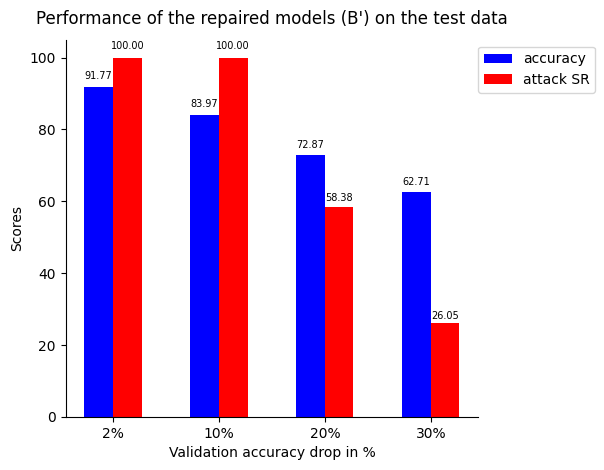

In [5]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = clean_valid_set
rects1 = ax.bar(ind, yvals, width, color='b')
zvals = attack_success_set
rects2 = ax.bar(ind+width, zvals, width, color='r')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('2%', '10%', '20%', '30%') )
ax.legend( (rects1[0], rects2[0]), ('accuracy', 'attack SR') ,bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the repaired models (B') on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f'%h,
                ha='center', va='bottom',fontsize=7)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

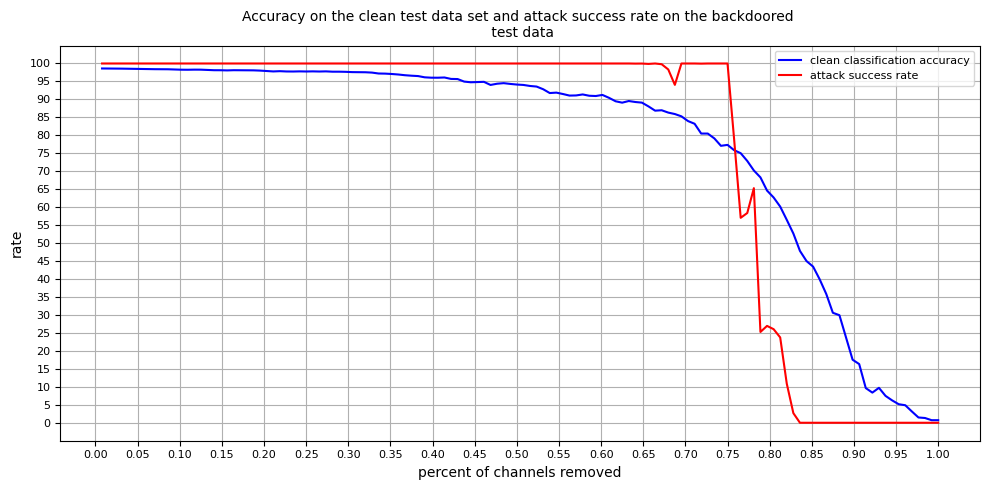

In [6]:
import matplotlib.font_manager as font_manager

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
axs.set_ylabel('rate', fontsize=10)
axs.set_xlabel('percent of channels removed', fontsize=10)
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', label="clean classification accuracy")
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', label='attack success rate')
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
plt.grid()
fig.tight_layout()